In [2]:
from google.cloud import storage
import pandas as pd
import numpy as np
import tensorflow as tf
import io
import os
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tqdm import tqdm
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/2023/Harvard_MSc_DS/classes/Fall 2023/ac297r/tnc-capstone'

/content/drive/MyDrive/2023/Harvard_MSc_DS/classes/Fall 2023/ac297r/tnc-capstone


In [4]:
data_path = '../data/lila_channel_islands_images_and_labels_all.csv'
images_folder = '../data/cropped_images/'

# download image file and label csv
df = pd.read_csv(data_path)
images_df = df['image_file'].values

# encode labels
num_classes = df['label'].nunique()
class_labels = df['label'].unique()
class_proportions = df['label'].value_counts(normalize=True).reset_index()
class_proportions.columns = ['labels', 'proportion']
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
labels_df = df['label'].values
labels_df = to_categorical(labels_df, num_classes)

In [5]:
# stratified train test split
from sklearn.model_selection import train_test_split

labels_integers = np.argmax(labels_df, axis=1)
train_val_indices, test_indices = train_test_split(range(len(labels_integers)), test_size=0.2, stratify=labels_integers, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.125, stratify=[labels_integers[i] for i in train_val_indices], random_state=42)


train_labels = labels_df[train_indices,:]
val_labels = labels_df[val_indices,:]
test_labels = labels_df[test_indices,:]

train_images = images_df[train_indices]
val_images = images_df[val_indices]
test_images = images_df[test_indices]

print(train_labels.shape, val_labels.shape, test_labels.shape)
print(len(train_images), len(val_images), len(test_images))

(58793, 6) (8400, 6) (16799, 6)
58793 8400 16799


In [6]:
def load_and_preprocess_image(image_path, label):
    image_path = os.path.join(images_folder, image_path.numpy().decode('utf-8'))
    if os.path.exists(image_path):
        with open(image_path, 'rb') as f:
            image_data = f.read()
            image = tf.image.decode_image(image_data, channels=3)
            image = tf.image.resize(image, [224, 224])
            image = tf.cast(image, tf.float32)
            image.set_shape([224, 224, 3])
            label = tf.cast(label, tf.float32)
            label.set_shape([num_classes])
            return image, label
    else:
        return None

def _fixup_shape(images, labels):
    images.set_shape([224, 224, 3])
    labels.set_shape([num_classes])
    return images, labels

def create_data(images_arr, labels_arr):
  dataset = tf.data.Dataset.from_tensor_slices((images_arr, labels_arr))
  dataset = dataset.map(lambda x, y: tf.py_function(load_and_preprocess_image, [x, y], [tf.float32, tf.float32]),num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.filter(lambda x, y: x is not None)
  dataset = dataset.map(_fixup_shape)
  return dataset

In [7]:
# create tf datasets
train_dataset = create_data(train_images, train_labels)
val_dataset = create_data(val_images, val_labels)
test_dataset = create_data(test_images, test_labels)

In [8]:
# batch
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [9]:
# load pre-trained EfficientNetB0 model without top classification layers
base_model = EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# add fine-tuneing layers
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#unfreeze last 20 layers that are not batch norm
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [10]:
# training
TRAIN = False

if TRAIN:
    epochs = 1
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
    model.save('../data/lila_channel_islands_efficentNet_v1.keras')
else:
    model = load_model('../data/lila_channel_islands_efficentNet_v1.keras')

In [11]:
# Evaluate the model on the test dataset
test_accuracy = 0
num_batches = 0
predicted = []
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for test_features, test_labels_enc in test_dataset:
    predicted_probs = model.predict(test_features)
    true_labels = label_encoder.inverse_transform(test_labels_enc.numpy().argmax(axis=1))
    predicted_labels = label_encoder.inverse_transform(predicted_probs.argmax(axis=1))
    predicted.append(predicted_labels)

    # Calculate batch accuracy and update total accuracy
    batch_accuracy = accuracy_score(true_labels, predicted_labels)
    test_accuracy += batch_accuracy
    num_batches += 1

    # Update confusion matrix
    conf_matrix_batch = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    conf_matrix += conf_matrix_batch

# Calculate average accuracy over all batches
average_accuracy = test_accuracy / num_batches

# Print average accuracy
print("Average Test Accuracy: {:.2f}%".format(average_accuracy * 100))

1/1 [==============================] - 4s 4s/step
Average Test Accuracy: 98.95%


In [12]:
predicted_unnest = []
for sublist in predicted:
    predicted_unnest.extend(sublist)
predicted_unnest[:10]

['rodent',
 'fox',
 'rodent',
 'rodent',
 'bird',
 'bird',
 'fox',
 'fox',
 'fox',
 'rodent']

In [13]:
len(predicted_unnest), len(test_labels), len(test_images)

(16799, 16799, 16799)

In [14]:
test_df = pd.DataFrame()
test_df['filename'] = test_images
test_df['actual'] = label_encoder.inverse_transform(test_labels.argmax(axis=1))
test_df['predicted'] = predicted_unnest
test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True
test_df.loc[test_df['actual']!=test_df['predicted'],'Same'] = False
test_df.head(10)

filename  actual predicted   Same
0  loc-h500ee07133550/002/278.jpg  rodent    rodent   True
1  loc-h500ee07133290/012/167.jpg     fox       fox   True
2  loc-h500hh06211894/003/041.jpg  rodent    rodent   True
3  loc-h500ee07133550/011/424.jpg  rodent    rodent   True
4  loc-h500ee07133445/000/370.jpg     fox      bird  False
5  loc-p800ff01146662/006/036.jpg    bird      bird   True
6  loc-h500ee07133290/011/578.jpg     fox       fox   True
7  loc-h500ee07133326/004/949.jpg     fox       fox   True
8  loc-h500ee07133326/003/011.jpg     fox       fox   True
9  loc-h600hi07237925/000/061.jpg  rodent    rodent   True

In [15]:
test_df.to_csv('../data/test_results.csv')

# Grad-CAM

In [16]:
img_size = 224
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"../data/cropped_images/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

# Correctly Classified

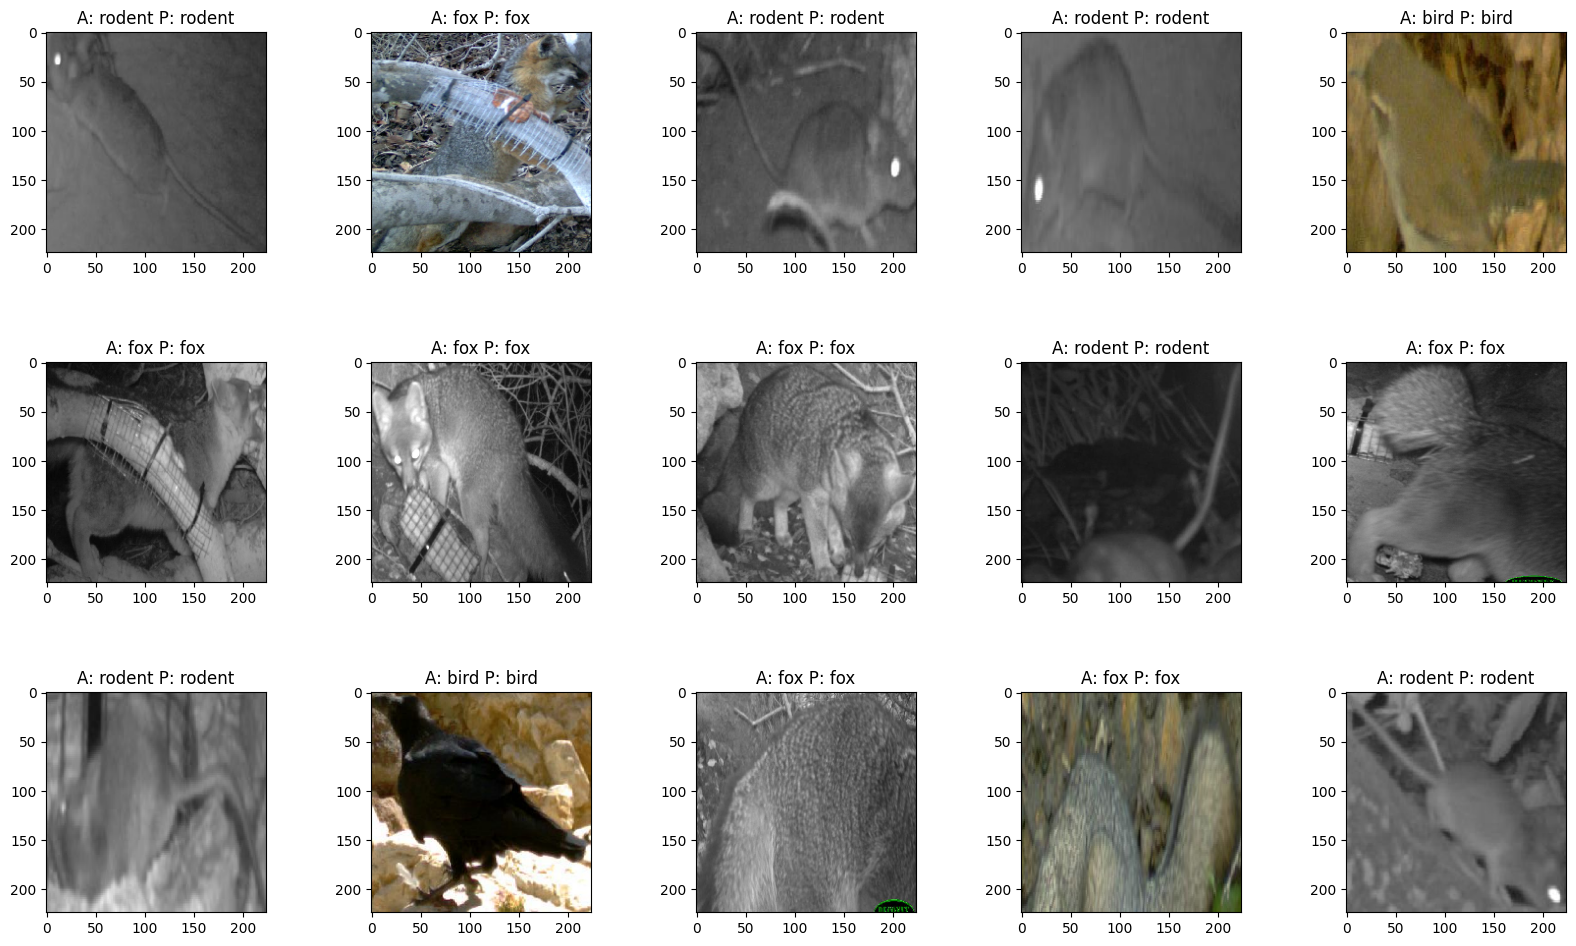

In [37]:
display_images(test_df[test_df.Same == True])

# Misclassified

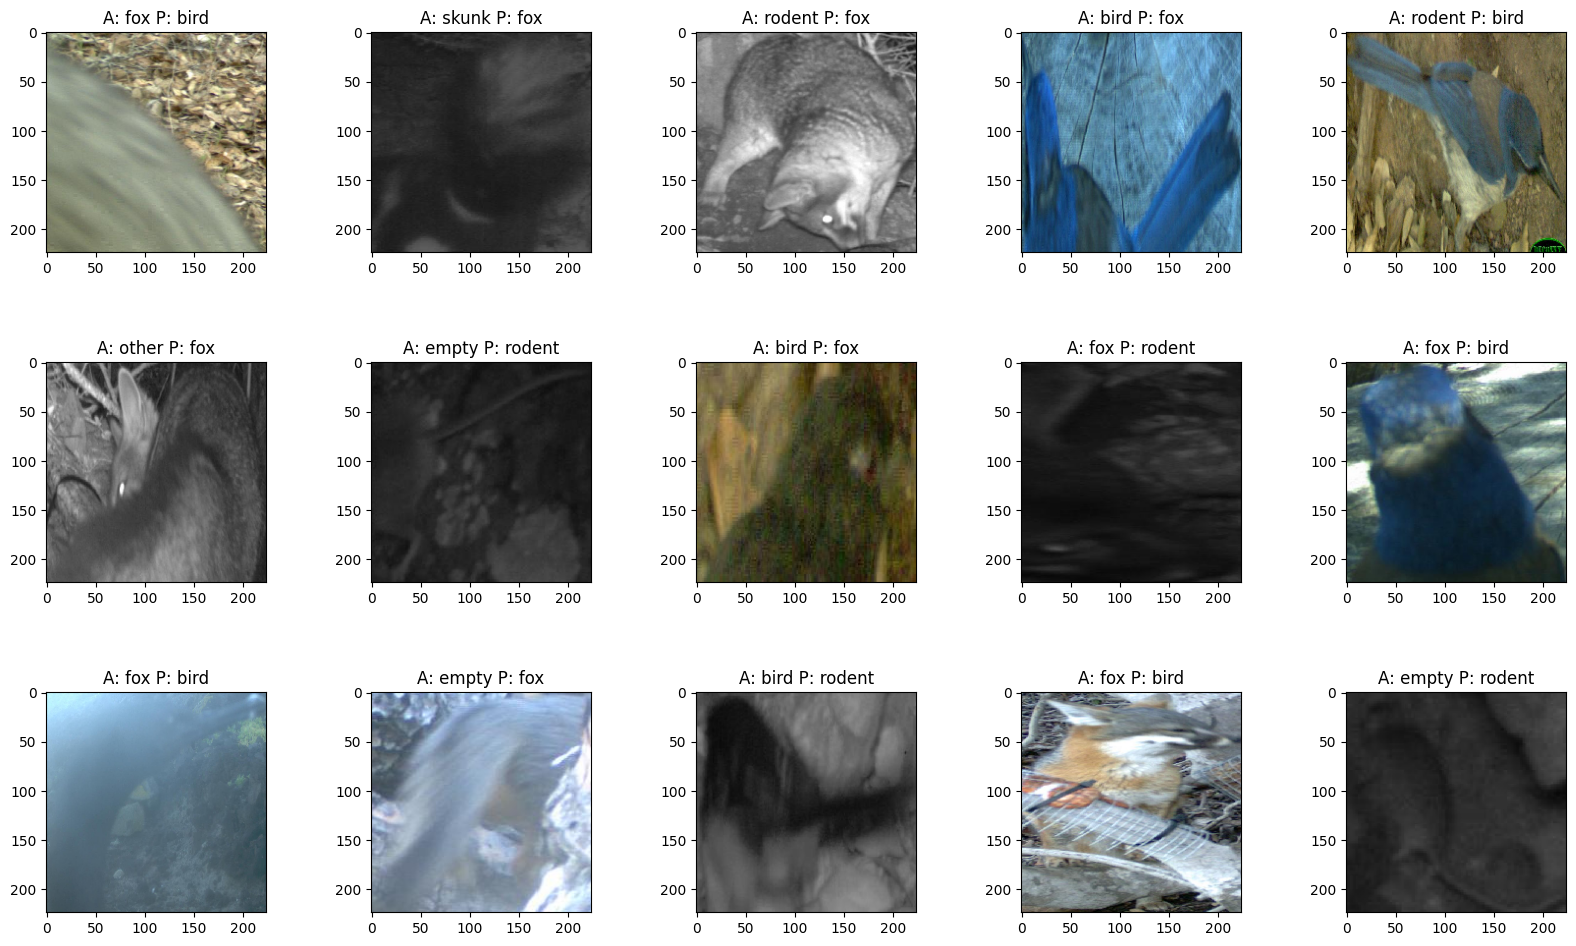

In [38]:
display_images(test_df[test_df.Same == False])

In [41]:
def make_gradcam_heatmap(img_array, model, pred_index=None):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-7].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [42]:
import matplotlib.cm as cm

In [48]:
def gradCAMImage(image):
    path = f"../data/cropped_images/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [49]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = test_df[test_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [50]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

<ipython-input-48-c0bf92e8148a>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [52]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

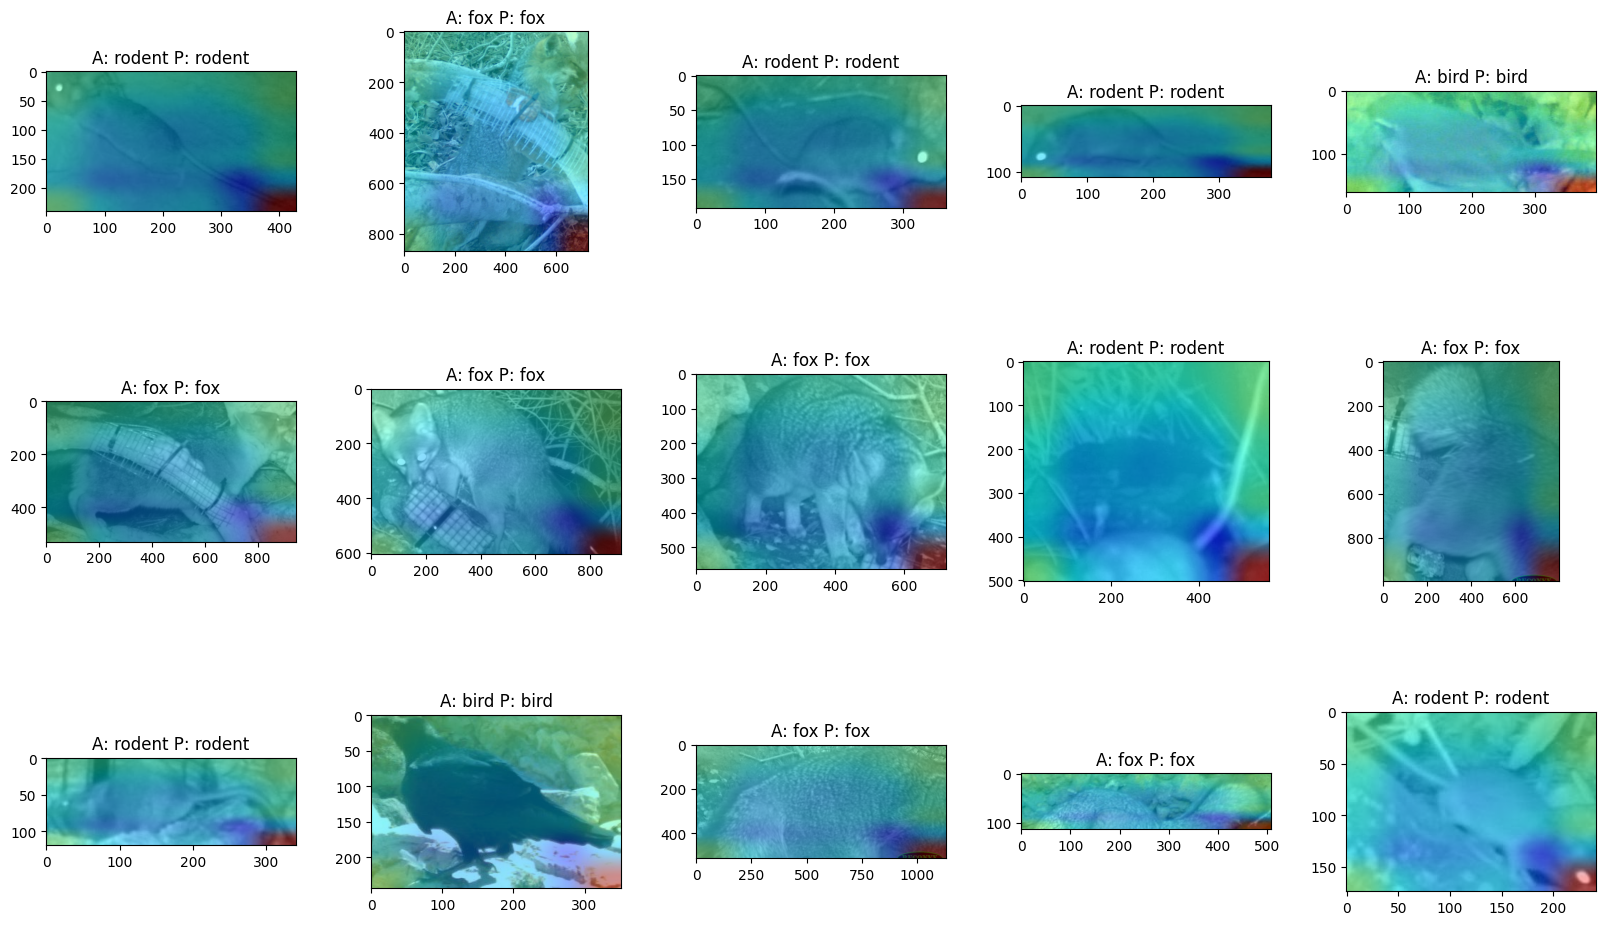

In [53]:
display_heatmaps(correctly_classified,c_titles)

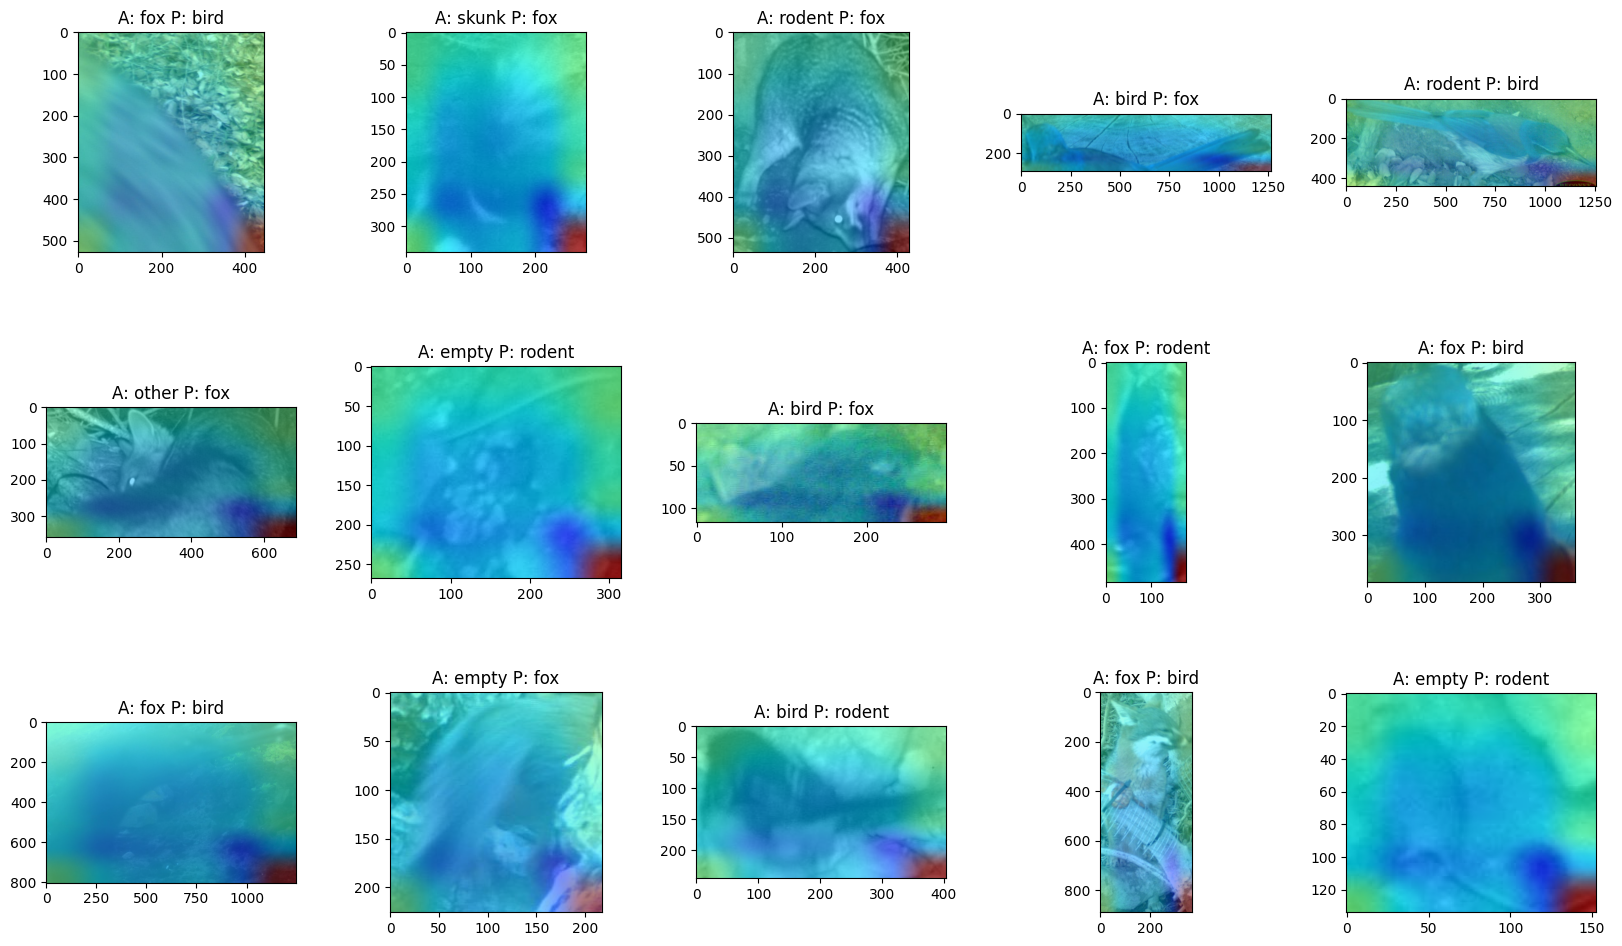

In [44]:
display_heatmaps(misclassified,m_titles)